In [1]:
import glob
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
%matplotlib inline

def plot_images(img1, img2, title1, title2, colormap1, colormap2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img1, cmap=colormap1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=colormap2)
    ax2.set_title(title2, fontsize=30)
    ax1.axis('off');
    ax2.axis('off');
    f.savefig("output_images/" + title2.replace(" ",""), bbox_inches='tight', transparent=True)

C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Files

Vehicle examples: 8792
Non-vehicle examples: 8968


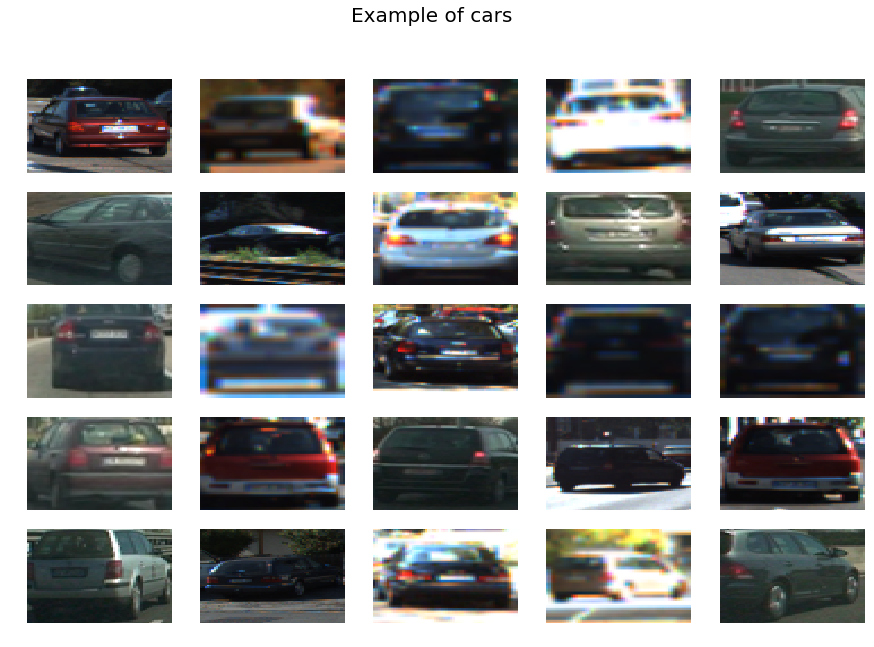

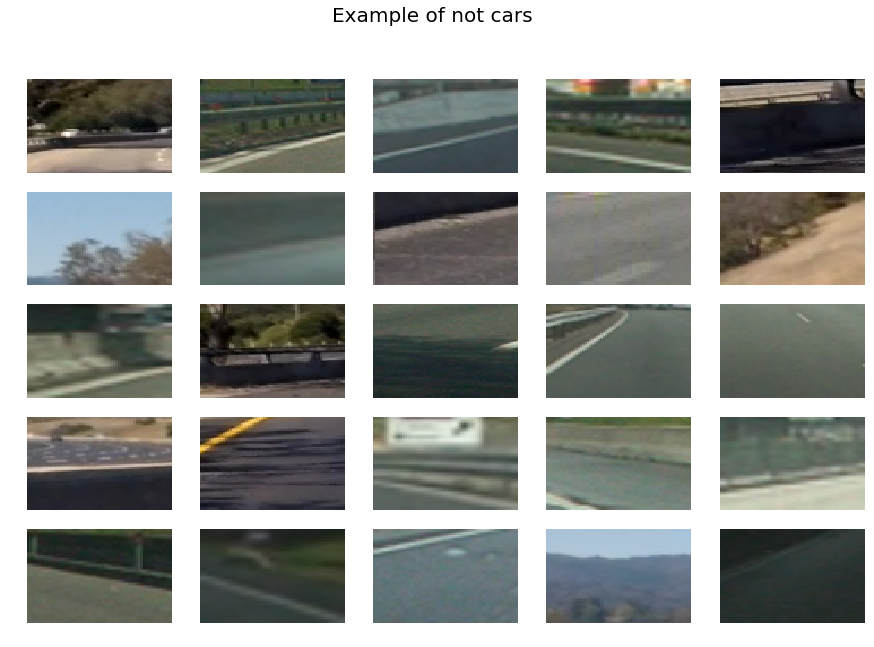

In [2]:
# Load vehicle and non-vehicle examples
cars = glob.glob('vehicles\*\*.png')
notcars = glob.glob('non-vehicles\*\*.png')    
        
print('Vehicle examples: {}'.format(len(cars)))
print('Non-vehicle examples: {}'.format(len(notcars)))

def plot_mosaic(random_samples, list_images, title):

    fig = plt.figure(facecolor="white")
    fig.set_size_inches(15, 10)

    # Plot the examples
    for i in range(len(random_samples)):
        example = mpimg.imread(list_images[random_samples[i]])

        ax=fig.add_subplot(5,5,i+1)        
        ax.imshow(example)
        ax.axis('off')
        ax.axis('tight')
    plt.suptitle(title, fontsize = 20)

# Plot car examples
car_random = random.sample(range(1, len(cars)), 25)
plot_mosaic(car_random, cars, 'Example of cars')
    
# Get n random numbers
notcar_random = random.sample(range(1, len(notcars)), 25)
plot_mosaic(notcar_random, notcars, 'Example of not cars')

# Extract features

### HOG features

Image shape: (64, 64, 3)


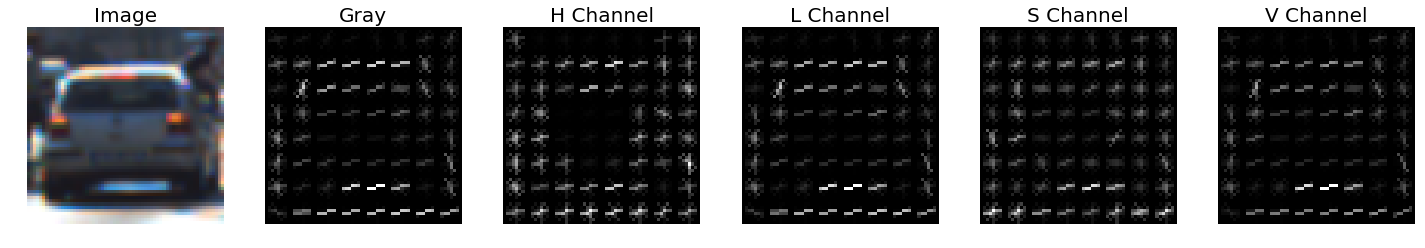

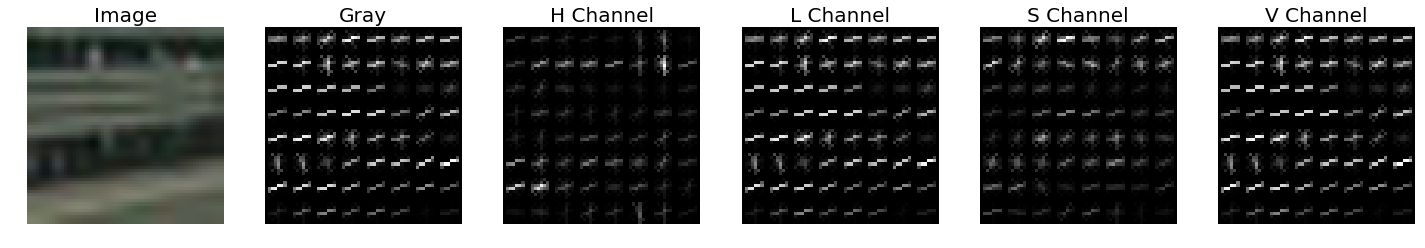

In [3]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def plot_hog_features(img, title, orient, pix_per_cell, cell_per_block, vis=True):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    f, ax = plt.subplots(1, 6, figsize=(20, 10))
    f.tight_layout()
    
    ax[0].imshow(img, cmap='jet')
    ax[0].set_title('Image', fontsize=20)
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
    ax[1].imshow(gray_hog, cmap='gray')
    ax[1].set_title('Gray', fontsize=20)
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    ax[2].imshow(h_hog, cmap='gray')
    ax[2].set_title('H Channel', fontsize=20)
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
    ax[3].imshow(l_hog, cmap='gray')
    ax[3].set_title('L Channel', fontsize=20)
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    ax[4].imshow(s_hog, cmap='gray')
    ax[4].set_title('S Channel', fontsize=20)

    _, v_hog = get_hog_features(hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    ax[5].imshow(v_hog, cmap='gray')
    ax[5].set_title('V Channel', fontsize=20)
    
    for i in ax:
        i.axis('off');
    
    f.savefig("output_images/" + title.replace(" ",""), bbox_inches='tight', transparent=True)
    
# Plot car example
car_image = mpimg.imread(cars[np.random.randint(len(cars))])
print("Image shape: {}".format(car_image.shape))
plot_hog_features(car_image, "carhog", orient, pix_per_cell, cell_per_block, vis=True)

# Plot not car example
notcar_image = mpimg.imread(notcars[np.random.randint(len(notcars))])
plot_hog_features(notcar_image, "carhog", orient, pix_per_cell, cell_per_block, vis=True)

### Color histogram features

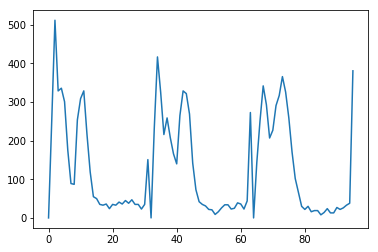

In [4]:
hist_bins = 32    # Number of histogram bins

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

car_image = mpimg.imread(cars[np.random.randint(len(cars))])
hist_features = color_hist(car_image, nbins=hist_bins)
plt.plot(hist_features)

### Binned color features

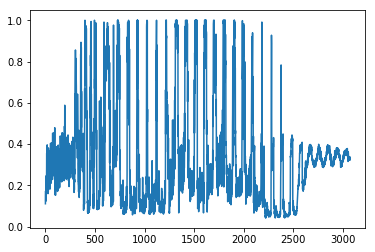

In [5]:
spatial_size = (32, 32) # Spatial binning dimensions

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

features = bin_spatial(car_image, spatial_size)
plt.plot(features)

### Extract features function

In [6]:
### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

### Scale features

In [7]:
# Crate an array stack of cars and not cars
stack_images = cars + notcars

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

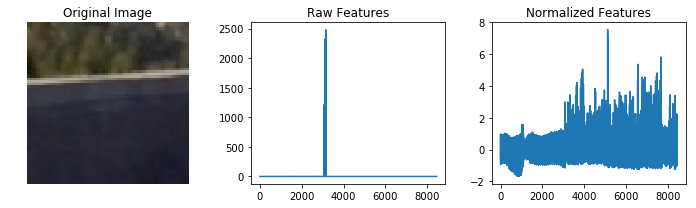

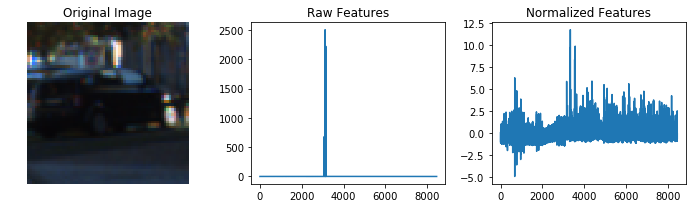

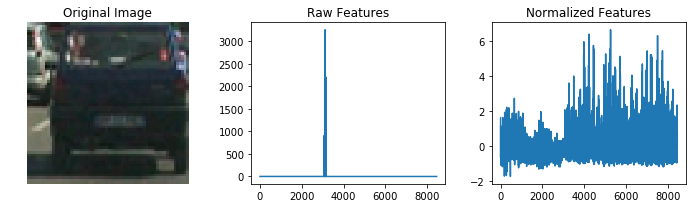

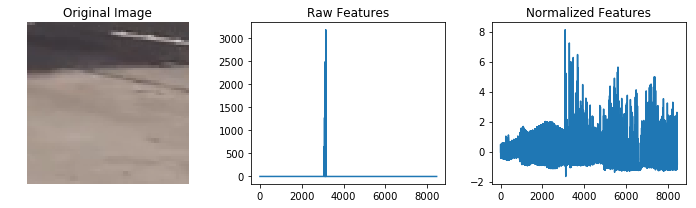

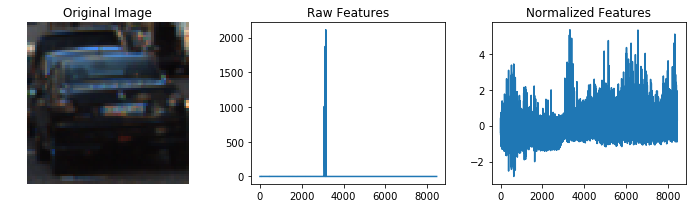

In [8]:
# Plot scaled features function
def plot_scaled_features(img_file, feature, norm_feature):
    fig = plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(mpimg.imread(img_file))
    plt.title('Original Image')
    plt.axis('off');
    plt.subplot(132)
    plt.plot(feature)
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(norm_feature)
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()

car_random = random.sample(range(1, len(stack_images)), 5)

for i in car_random:
    img_file = stack_images[i]
    feature = X[i]
    norm_feature = scaled_X[i]
    plot_scaled_features(img_file, feature, norm_feature)

# Split up data into randomized training and test sets

In [9]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Train

In [10]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
45.41 Seconds to train SVC...
Test Accuracy of SVC =  0.991


# Find cars function

In [11]:
ystart = 400
ystop = 656
scale = 1.5

# Function to convert image
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    # Return the boxes
    return boxes

def draw_bboxes(img, boxes):
    for bbox in boxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

# Test

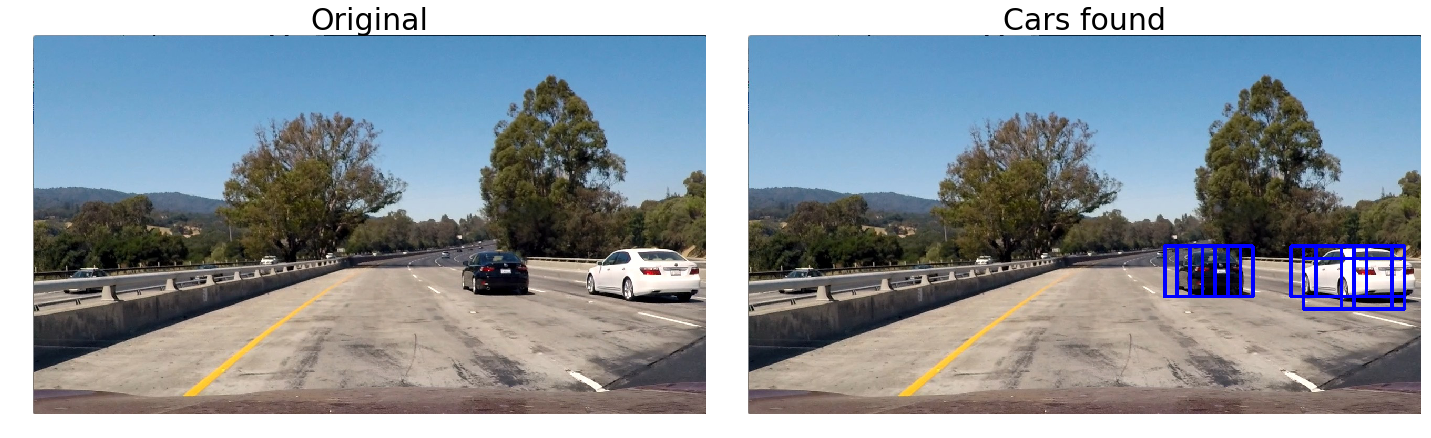

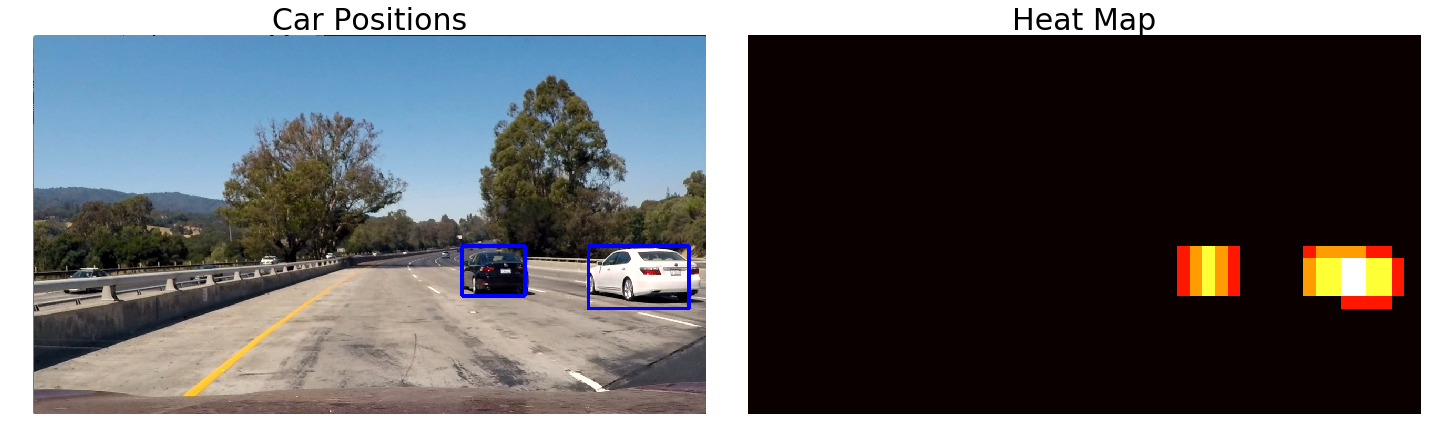

In [12]:
# Read test image
img = mpimg.imread('test_images/test1.jpg')

# Find boxes
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Plot image
plot_images(img, out_img, "Original", "Cars found", 'jet', 'jet')

# Read in image similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
boxes = get_labeled_bboxes(labels)

# Draw boxes
draw_img = draw_bboxes(np.copy(img), boxes)

# Plot image
plot_images(draw_img, heatmap, 'Car Positions', 'Heat Map', 'jet', 'hot')

# Pipeline

In [13]:
class Frame_vehicle():
    def __init__(self):
        # Was the vehicle detected?
        self.detected = True   
        # List of boxes detected
        self.list_boxes = None  
        # List of vehicles detected
        self.list_vehicles = None
        # Center points of detected vehicles
        self.centers = None
        # Averaged of vehicles over the last n iterations
        self.best_fit = None

In [20]:
def process_image(img):
    global history
    
    frame = Frame_vehicle()
    
    # Find boxes
    out_img, frame.list_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                          pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,frame.list_boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    frame.list_vehicles = get_labeled_bboxes(labels)

    # Take average of the last 10 frames
    a = []
    for i in history[-10:]:
        a.append(i.list_vehicles)
    try:
        frame.best_fit = int(np.mean(a, axis=0))
    except:
        frame.best_fit = frame.list_vehicles
    
    # Draw boxes
    draw_img = draw_bboxes(np.copy(img), frame.best_fit)
    
    # Save center points of detected vehicles
    list_centers = []
    for i in frame.list_vehicles:
        x = int((i[0][0] + i[1][0])/2)
        y = int((i[0][1] + i[1][1])/2)
        list_centers.append((x, y))
    frame.centers = list_centers

    # Add data to history
    history.append(frame)
    
    return draw_img

# Process project video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = []

project_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(project_output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:23<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 25.4 s


In [22]:
history = []

project_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(project_output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:11<00:00,  1.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 12min 12s
